# Computed MAF QC

The goal of the analysis is to see how many lead variants from credible sets had correctly calculated MAF.

<div class="alert alert-block alert-info"> 
<b> Reasons of MAF computation failure </b>
    <ul>
        <li><I>majorPopulationMAF == 0.0</I>  - Searched variant was found in gnomAD, but it was not reported for the searched study major population</li>
        <li><I>majorPopulationMAF is Null</I> -  Searched variant was not found in gnomAD, so AF was not reported for any population</li>
    </ul>

 </div>


## Data Loading

The data required for the analysis is loaded from the `computed maf` dataset.


In [1]:
import numpy as np
import plotnine as pn
from gentropy.common.session import Session
from pyspark.sql import functions as f

from manuscript_methods import OpenTargetsTheme, break_string, group_statistics
from manuscript_methods.datasets import LeadVariantEffect
from manuscript_methods.maf import MinorAlleleFrequency, MinorAlleleFrequencyClassification, maf_discrepancies


Loading BokehJS ...

In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/lead_variant_effect"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 13:37:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/03 13:37:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/07/03 13:37:59 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/07/03 13:37:59 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
25/07/03 13:37:59 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
25/07/03 13:37:59 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
25/07/03 13:37:59 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.


In [3]:
session.spark


In [4]:
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)


## MAF QC

Ensure that both datasets contain the same amount of rows


In [5]:
data = dataset_maf.df.select(maf_discrepancies(f.col("majorLdPopulationMaf.value")))

gs = group_statistics(data, [f.col("mafDiscrepancy")])
gs.show(truncate=False)


+------------------------------------------------+-------+-----+------------------+
|mafDiscrepancy                                  |count  |%    |percentage        |
+------------------------------------------------+-------+-----+------------------+
|Variant has allele frequency in gnomAD AF       |2821580|99.57|99.57025264683857 |
|Variant missing from major ancestry in gnomAD AF|9434   |0.33 |0.3329148078276268|
|Variant missing from any ancestry in gnomAD AF  |2744   |0.10 |0.0968325453337935|
+------------------------------------------------+-------+-----+------------------+



### Plot the discrepances in MAF calculation


/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning:

Saving 2.5 x 3.3333333333333335 in image.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning:

Filename: plots/01.2_discrepancies_in_maf_calculation.jpg



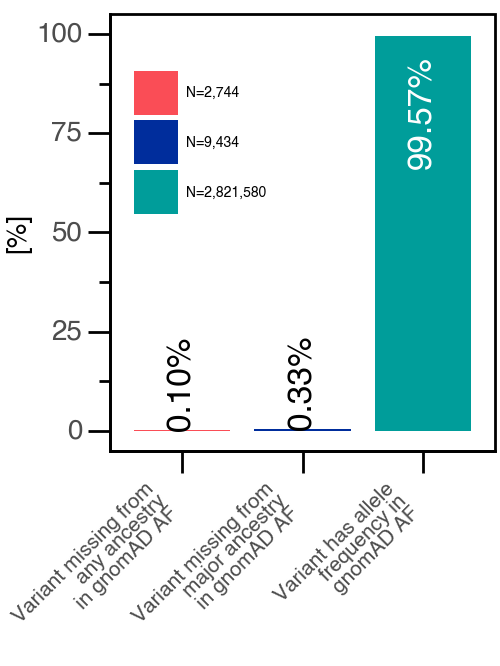

<Figure Size: (250 x 333)>

In [6]:
data = gs.toPandas()
data["mafDiscrepancy"] = data["mafDiscrepancy"].apply(break_string)
data["label"] = "N=" + data["count"].apply(lambda x: f"{x:,}")
data["above_50%_label"] = data.apply(lambda row: row["%"] + "%" if row["percentage"] > 50 else "", axis=1)
data["below_50%_label"] = data.apply(lambda row: row["%"] + "%" if row["percentage"] <= 50 else "", axis=1)

REM = 6


p = (
    pn.ggplot(
        data=data,
        mapping=pn.aes(x="reorder(mafDiscrepancy, percentage)", y="percentage", fill="reorder(label, percentage)"),
    )
    + pn.geom_col(stat="identity", width=0.8)
    + pn.geom_text(
        pn.aes(label="above_50%_label"),
        angle=90,
        size=2.0 * REM,
        va="top",
        fontweight="bold",
        family="sans-serif",
        color="white",
        position=pn.position_stack(vjust=0.95),
    )
    + pn.geom_text(
        pn.aes(label="below_50%_label"),
        angle=90,
        size=2.0 * REM,
        va="bottom",
        fontweight="bold",
        family="sans-serif",
    )
    + pn.labs(x="", y="[%]", fill="")
    + pn.scale_y_continuous(
        limits=(0, 100),
        breaks=np.arange(0, 101, 25),
        labels=lambda x: [f"{int(i)}" for i in x],
    )
    + pn.scale_fill_manual(values=OpenTargetsTheme.categorical_dark_colors)
    + OpenTargetsTheme.categorical_theme(5)
)
p.save("plots/01.2_discrepancies_in_maf_calculation.jpg", dpi=300, bbox_inches="tight")
p


## Common vs Rare

The analysis was performed to see how many lead variants are falling into

- common (MAF > 0.01) and rare (MAF < 0.01) categories.

The analysis was perfromed on all credible set studyTypes


### Prepare the data


In [10]:
# Filter dataset to only include variants with a valid MAF value
filtered_maf_dataset = dataset_maf.maf_filter(threshold=None)

# Classify the minor allele frequency to common and rare variants
maf = MinorAlleleFrequency(f.col("majorLdPopulationMaf"))
maf_classification = MinorAlleleFrequencyClassification.from_maf(maf)
classified_dataset_maf = (
    filtered_maf_dataset.df.withColumn(maf_classification.name, maf_classification.col)
    .select("variantMAFClassification.*", "variantId", "studyStatistics.studyType")
    .melt(
        ids=["variantId", "studyType"],
        values=["common", "rare"],
        variableColumnName="mafClass",
        valueColumnName="mafValue",
    )
    .filter(f.col("mafValue"))
    .drop("mafValue")
)


### Check the number of common vs rare variants in all credible sets


In [11]:
gs = group_statistics(classified_dataset_maf, [f.col("mafClass"), f.col("studyType")])
gs.show()


+--------+----------+-------+-----+--------------------+
|mafClass| studyType|  count|    %|          percentage|
+--------+----------+-------+-----+--------------------+
|  common|      eqtl|1294844|45.89|   45.89074206650175|
|  common|      gwas| 679900|24.10|   24.09642824233231|
|  common|     tuqtl| 371699|13.17|   13.17343474223662|
|  common|      sqtl| 216793| 7.68|    7.68339015728776|
|    rare|      gwas|  98290| 3.48|  3.4835092395041074|
|    rare|      eqtl|  54024| 1.91|  1.9146719214057373|
|  common|    sceqtl|  51939| 1.84|  1.8407771532262067|
|  common|trans-pqtl|  15826| 0.56|  0.5608914154480823|
|    rare|     tuqtl|  13066| 0.46| 0.46307388059172516|
|  common|  cis-pqtl|  11864| 0.42| 0.42047363533906534|
|    rare|      sqtl|   6659| 0.24|  0.2360025234088702|
|    rare|  cis-pqtl|   4069| 0.14| 0.14420998164149165|
|    rare|trans-pqtl|   1822| 0.06| 0.06457374945952268|
|    rare|    sceqtl|    785| 0.03|0.027821291616753736|
+--------+----------+-------+--

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning:

Saving 3.0 x 4.0 in image.

/Users/ss60/Projects/Gentropy-manuscript/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning:

Filename: plots/01.1_rare_vs_common_lead_variants.jpg



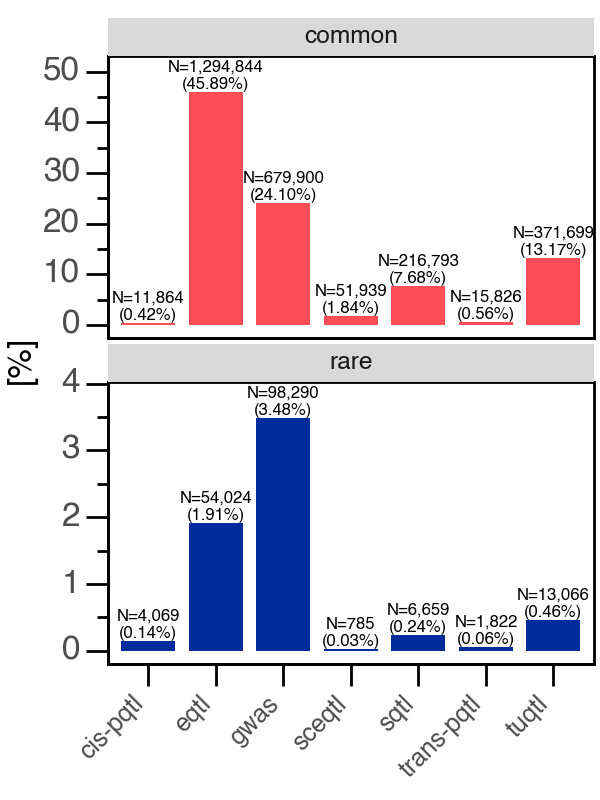

<Figure Size: (300 x 400)>

In [12]:
data = gs.orderBy("mafClass", f.desc("percentage")).toPandas()
data["label"] = "N=" + data["count"].apply(lambda x: f"{x:,}") + "\n(" + data["%"] + "%)"
data["y_lab_lim"] = data["percentage"] * 1.1  # place label 10% above highest bar in facet
# This plot works on non-aggregated data, all aggregations are done by plotnine
plt = (
    pn.ggplot(data, pn.aes(x="studyType", y="percentage", fill="mafClass"))
    + pn.geom_col(width=0.8)
    + pn.facet_wrap(facets="mafClass", nrow=2, scales="free_y")
    + pn.labs(x="", y="[%]", fill="Variant type")
    + pn.scale_fill_manual(values=OpenTargetsTheme.categorical_dark_colors)
    + OpenTargetsTheme.categorical_theme(REM=6)
    + pn.geom_text(
        pn.aes(y="y_lab_lim", label="label"),
        position=pn.position_stack(vjust=0.91),
        size=6,
        va="bottom",
    )
    + pn.theme(legend_position="none")
)
plt.save("plots/01.1_rare_vs_common_lead_variants.jpg", dpi=300, bbox_inches="tight")
plt
